In [1]:
!pip install torch torchvision

You should consider upgrading via the 'D:\Anaconda3\envs\Segwater\python.exe -m pip install --upgrade pip' command.


In [2]:
#conda install pytorch torchvision torchaudio cudatoolkit=11.1 -c pytorch -c conda-forge -> for conda

In [15]:
import torch
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


In [16]:
# # data transformations
# transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
# ])

# # dataset paths
# train_data_path = 'G:\\Dataset\\Train'
# validation_data_path = 'G:\\Dataset\\Test'
# test_image_path = 'G:\\Dataset\\TestImage\\Paddy1.jpg'

# # make datasets
# train_ds = ImageFolder(root=train_data_path, transform=transform)
# validation_ds = ImageFolder(root=validation_data_path, transform=transform)
# #test_ds = ImageFolder(root=test_data_path, transform=transform)

# # Print number of images in dataset
# print(f"Number of images in the training dataset: {len(train_ds)}")
# print(f"Number of images in the validation dataset: {len(validation_ds)}")
# #print(f"Number of images in the test dataset: {len(test_ds)}")

# # Create data loaders
# train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
# validation_loader = DataLoader(validation_ds, batch_size=16, shuffle=False)
# #test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)
# # Load the test image and apply transformations
# test_image = Image.open(test_image_path)
# test_image = transform(test_image).unsqueeze(0)  # Add a batch dimension

In [17]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Dataset paths
train_data_path = 'G:\\Dataset\\Train'
validation_data_path = 'G:\\Dataset\\Test'
test_image_path = 'G:\\Dataset\\TestImage\\Paddy1.jpg'

# Create datasets with custom target_transform
train_ds = ImageFolder(root=train_data_path, transform=transform)
validation_ds = ImageFolder(root=validation_data_path, transform=transform)

# Print number of images in datasets
print(f"Number of images in the training dataset: {len(train_ds)}")
print(f"Number of images in the validation dataset: {len(validation_ds)}")

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_ds, batch_size=32, shuffle=False)

# Load the test image and apply transformations
test_image = Image.open(test_image_path)
test_image = transform(test_image).unsqueeze(0)  # Add a batch dimension

# Get all the labels from the training dataset
train_labels = [label for _, label in train_ds.samples]

# Get all the labels from the validation dataset
validation_labels = [label for _, label in validation_ds.samples]

# Print the unique labels in the training dataset
print("Unique labels in the training dataset:", set(train_labels))

# Print the unique labels in the validation dataset
print("Unique labels in the validation dataset:", set(validation_labels))

Number of images in the training dataset: 1307
Number of images in the validation dataset: 140
Unique labels in the training dataset: {0, 1}
Unique labels in the validation dataset: {0, 1}


In [18]:
# CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        features = x  # Save features before flattening
        x = x.view(-1, 128 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = torch.sigmoid(self.fc3(x))
        return features, x
        
# Initialize model
model = CNNModel()

In [19]:
# Defien loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.0001) # try 0.0001 eventually

# Training epochs
num_epochs = 10


In [20]:
# Lists store loss and accuracy for each epoch
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_loss = float('inf')  # Initialize with a very large value
no_improvement_count = 0  # Count for consecutive epochs with no improvement
patience = 3  # Define the number of epochs to wait for improvement

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to train mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        optimizer.zero_grad()

        # Model forward pass
        features, outputs = model(images)  # Unpack the output tuple
        
        # Ensure labels are in the correct format for BCELoss
        labels = labels.float().view(-1, 1)  # Reshape labels for BCELoss

        # Compute loss
        loss = criterion(outputs, labels)

        # Model backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()  # Thresholding to get binary predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Print training statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%")

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            features, outputs = model(images)  # Unpack the output tuple

            # Ensure labels are in the correct format for BCELoss
            labels = labels.float().view(-1, 1)  # Reshape labels for BCELoss

            # Compute loss
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            predicted = (outputs > 0.5).float()  # Thresholding to get binary predictions
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(validation_loader)
    val_accuracy = val_correct / val_total * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print validation statistics
    print(f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.2f}%")

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        if no_improvement_count >= patience:
            print(f"No improvement for {patience} epochs. Stopping training.")
            break


Epoch [1/10], Train Loss: 0.6922, Train Accuracy: 53.79%
Validation Loss: 0.6889, Validation Accuracy: 52.14%
Epoch [2/10], Train Loss: 0.6622, Train Accuracy: 62.36%
Validation Loss: 0.6112, Validation Accuracy: 66.43%
Epoch [3/10], Train Loss: 0.5995, Train Accuracy: 70.62%
Validation Loss: 0.4191, Validation Accuracy: 92.14%
Epoch [4/10], Train Loss: 0.4885, Train Accuracy: 78.35%
Validation Loss: 0.2990, Validation Accuracy: 90.00%
Epoch [5/10], Train Loss: 0.3997, Train Accuracy: 83.24%
Validation Loss: 0.2085, Validation Accuracy: 90.71%
Epoch [6/10], Train Loss: 0.3182, Train Accuracy: 87.61%
Validation Loss: 0.1871, Validation Accuracy: 93.57%
Epoch [7/10], Train Loss: 0.2470, Train Accuracy: 91.05%
Validation Loss: 0.1888, Validation Accuracy: 90.71%
Epoch [8/10], Train Loss: 0.2102, Train Accuracy: 92.20%
Validation Loss: 0.1646, Validation Accuracy: 91.43%
Epoch [9/10], Train Loss: 0.1646, Train Accuracy: 94.11%
Validation Loss: 0.1582, Validation Accuracy: 90.00%
Epoch [10/

In [9]:
# # Lists store loss and accuracy for each epoch
# train_losses = []
# train_accuracies = []
# val_losses = []
# val_accuracies = []

# # Training loop
# for epoch in range(num_epochs):
#     model.train()  # Set the model to train mode
#     running_loss = 0.0
#     correct = 0
#     total = 0

#     for images, labels in train_loader:
#         optimizer.zero_grad()

#         # Model forward pass
#         outputs = model(images)
#         labels = labels.float().view(-1, 1)  # Reshape labels for BCELoss
#         loss = criterion(outputs, labels)

#         # Model backward pass and optimize
#         loss.backward()
#         optimizer.step()

#         # Update statistics
#         running_loss += loss.item()
#         predicted = (outputs > 0.5).float()  # Thresholding to get binary predictions
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     train_loss = running_loss / len(train_loader)
#     train_accuracy = correct / total * 100
#     train_losses.append(train_loss)
#     train_accuracies.append(train_accuracy)

#     # Print training statistics
#     print(f"Epoch [{epoch + 1}/{num_epochs}], "
#           f"Train Loss: {train_loss:.4f}, "
#           f"Train Accuracy: {train_accuracy:.2f}%")

#     # Validation
#     model.eval()  # Set the model to evaluation mode
#     val_running_loss = 0.0
#     val_correct = 0
#     val_total = 0
#     with torch.no_grad():
#         for images, labels in validation_loader:
#             outputs = model(images)
#             labels = labels.float().view(-1, 1)  # Reshape labels for BCELoss
#             loss = criterion(outputs, labels)
#             val_running_loss += loss.item()

#             predicted = (outputs > 0.5).float()  # Thresholding to get binary predictions
#             val_total += labels.size(0)
#             val_correct += (predicted == labels).sum().item()

#     val_loss = val_running_loss / len(validation_loader)
#     val_accuracy = val_correct / val_total * 100
#     val_losses.append(val_loss)
#     val_accuracies.append(val_accuracy)

#     # Print validation statistics
#     print(f"Validation Loss: {val_loss:.4f}, "
#           f"Validation Accuracy: {val_accuracy:.2f}%")



In [21]:
# location to save model weights
save_dir = 'G:\\CNNmodel'
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Define the full path including the filename
save_path = os.path.join(save_dir, 'model_weights.pth')

# Save the model weights
torch.save(model.state_dict(), save_path)

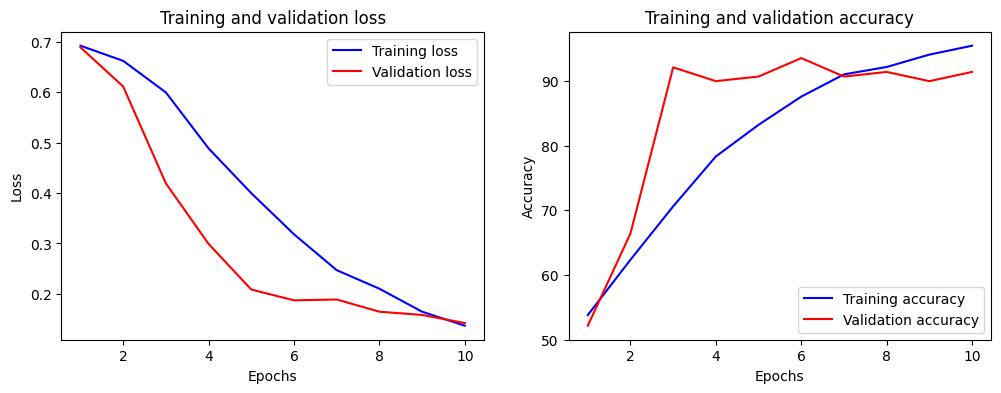

In [22]:
# Derive the number of completed epochs
completed_epochs = len(train_losses)
epochs = range(1, completed_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [23]:
print(model)# brief idea of the model

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=131072, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


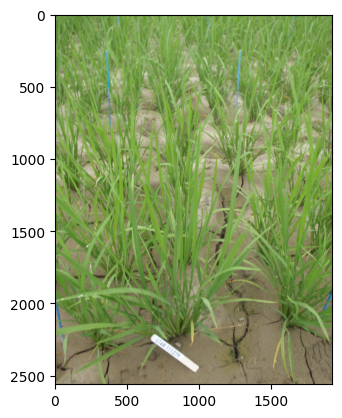

tensor([[0.7305]])
Predicted class: without_water


In [25]:
# Same transformations for training and validation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load the input image
test_img_path = 'G:\\Dataset\\Paddy1.jpg'
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
plt.imshow(test_img)
plt.show()

# Resize and transform the image
test_img_resized = cv2.resize(test_img, (256, 256))
test_img_pil = Image.fromarray(test_img_resized)  # Convert to PIL Image for compatibility with transforms
test_input = transform(test_img_pil)
test_input = test_input.unsqueeze(0)  # Add batch dimension

# Load the model
model = CNNModel()  # Instantiate model class
model.load_state_dict(torch.load('G:\\CNNmodel\\model_weights.pth'))
model.eval()

# Perform inference
with torch.no_grad():
    features, outputs = model(test_input)

# Convert outputs to probabilities
probabilities = torch.sigmoid(outputs)
print(probabilities)

# Assuming binary classification, interpret the probabilities
if probabilities.item() > 0.5:
    print("Predicted class: without_water")
else:
    print("Predicted class: with_water")


In [26]:
# Now let's implement Grad-CAM
def grad_cam(model, input_tensor, target_class):
    model.eval()
    features, output = model(input_tensor)
    one_hot_output = torch.zeros_like(output)
    one_hot_output[:, target_class] = 1

    model.zero_grad()
    output.backward(gradient=one_hot_output, retain_graph=True)

    pooled_gradients = torch.mean(model.conv3.weight.grad, dim=[0, 2, 3])

    activations = features
    grad_cam = torch.zeros_like(activations[:, 0, :, :])
    for i in range(len(pooled_gradients)):
        grad_cam += pooled_gradients[i] * activations[:, i, :, :]

    grad_cam = F.relu(grad_cam)
    grad_cam /= torch.max(grad_cam)

    return grad_cam

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


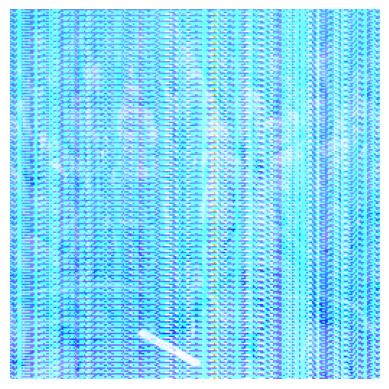

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_grad_cam(grad_cam, input_image):
    grad_cam = grad_cam.cpu().detach().numpy()
    grad_cam = np.maximum(grad_cam, 0)
    grad_cam = grad_cam / grad_cam.max()
    grad_cam = np.uint8(grad_cam * 255)

    # Resize grad_cam to the size of the input image
    grad_cam = np.resize(grad_cam, (input_image.shape[2], input_image.shape[3]))
    grad_cam = np.uint8(plt.cm.jet(grad_cam)[..., :3] * 255)

    input_image = input_image.cpu().detach().numpy()
    input_image = np.transpose(input_image[0], (1, 2, 0))
    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())

    # Superimpose grad_cam on the input image
    superimposed_img = grad_cam * 0.4 + input_image

    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Generate Grad-CAM
grad_cam_output = grad_cam(model, test_image, target_class=0)  # Change target_class accordingly

# Visualize Grad-CAM
visualize_grad_cam(grad_cam_output, test_image)
